In [63]:
# import os
# import urllib


# def plot2D(x, y, xLabel = '', yLabel = '', title = '', pathChart = None):
#     import matplotlib.pyplot as mpl
#     fig = mpl.figure()
#     ax = fig.add_subplot(1, 1, 1) # one row, one column, first plot
#     ax.plot(x, y, color = 'blue')
#     ax.set_xlabel(xLabel)
#     ax.set_ylabel(yLabel, rotation = 90)
#     mpl.xticks(rotation = 'vertical')
#     mpl.title(title)
#     if pathChart == None:
#         mpl.show()
#     else:
#         mpl.savefig(pathChart)
#         mpl.clf() # reset pylab
#     return

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl

In [3]:
def plot2D(x, y, xLabel="", yLabel="", title="", pathChart=None):
    import matplotlib.pyplot as mpl

    fig = mpl.figure()
    ax = fig.add_subplot(1, 1, 1)  # one row, one column, first plot
    ax.plot(x, y, color="blue")
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel, rotation=90)
    mpl.xticks(rotation="vertical")
    mpl.title(title)
    if pathChart == None:
        mpl.show()
    else:
        mpl.savefig(pathChart)
        mpl.clf()  # reset pylab
    return

In [4]:
def initAlgo(mean, lB, uB):
    # Initialize the algo
    # 1) Form structured array
    a = np.zeros((mean.shape[0]), dtype=[("id", int), ("mu", float)])
    b = [mean[i][0] for i in range(mean.shape[0])]  # dump array into list
    a[:] = list(zip(range(mean.shape[0]), b))  # fill structured array

    # 2) Sort structured array
    b = np.sort(a, order="mu")
    # 3) First free weight
    i, w_init = b.shape[0], np.copy(lB)
    while sum(w_init) < 1:
        i -= 1
        w_init[b[i][0]] = uB[b[i][0]]
    w_init[b[i][0]] += 1 - sum(w_init)
    return [b[i][0]], w_init

In [5]:
def getB(f):
    return diffLists(range(mean.shape[0]), f)


def diffLists(list1, list2):
    return list(set(list1) - set(list2))

In [6]:
def getMatrices(f):
    # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
    covarF = reduceMatrix(covar, f, f)
    meanF = reduceMatrix(mean, f, [0])
    b = getB(f)
    print(f"b={b}")
    covarFB = reduceMatrix(covar, f, b)
    wB = reduceMatrix(w, b, [0])  # w_list[-1]
    return covarF, covarFB, meanF, wB


def reduceMatrix(matrix, listX, listY):
    # Reduce a matrix to the provided list of rows and columns
    if len(listX) == 0 or len(listY) == 0:
        return
    matrix_ = matrix[:, listY[0] : listY[0] + 1]
    for i in listY[1:]:
        a = matrix[:, i : i + 1]
        matrix_ = np.append(matrix_, a, 1)
    matrix__ = matrix_[listX[0] : listX[0] + 1, :]
    for i in listX[1:]:
        a = matrix_[i : i + 1, :]
        matrix__ = np.append(matrix__, a, 0)
    return matrix__

In [7]:
def computeLambda(covarF_inv, covarFB, meanF, wB, i, bi):
    # 1) C
    onesF = np.ones(meanF.shape)
    c1 = np.dot(np.dot(onesF.T, covarF_inv), onesF)
    c2 = np.dot(covarF_inv, meanF)
    c3 = np.dot(np.dot(onesF.T, covarF_inv), meanF)
    c4 = np.dot(covarF_inv, onesF)
    c = -c1 * c2[i] + c3 * c4[i]
    if c == 0:
        return
    # 2) bi
    if (
        type(bi) == list
    ):  # Jenom pro výpočet l_in, l_out vůbec bi nepočítá a použije vstupní hodnotu
        bi = computeBi(c, bi)
        print(f"bi == list => bi={bi}")
    # 3) Lambda
    print(f"bi = {bi}")
    print(f"c={c}")
    if wB is None:
        # All free assets
        return float((c4[i] - c1 * bi) / c), bi
    else:
        onesB = np.ones(wB.shape)
        l1 = np.dot(onesB.T, wB)
        l2 = np.dot(covarF_inv, covarFB)
        l3 = np.dot(l2, wB)
        l2 = np.dot(onesF.T, l3)
        return float(((1 - l1 + l2) * c4[i] - c1 * (bi + l3[i])) / c), bi


def computeBi(c, bi):
    if c > 0:
        bi = bi[1][0]
    if c < 0:
        bi = bi[0][0]
    return bi

In [8]:
def computeW(covarF_inv, covarFB, meanF, wB):
    # 1) compute gamma
    onesF = np.ones(meanF.shape)
    g1 = np.dot(np.dot(onesF.T, covarF_inv), meanF)
    g2 = np.dot(np.dot(onesF.T, covarF_inv), onesF)
    if wB is None:
        g, w1 = float(-l_list[-1] * g1 / g2 + 1 / g2), 0
    else:
        onesB = np.ones(wB.shape)
        g3 = np.dot(onesB.T, wB)
        g4 = np.dot(covarF_inv, covarFB)
        w1 = np.dot(g4, wB)
        g4 = np.dot(onesF.T, w1)
        g = float(-l_list[-1] * g1 / g2 + (1 - g3 + g4) / g2)
    # 2) compute weights
    w2 = np.dot(covarF_inv, onesF)
    w3 = np.dot(covarF_inv, meanF)
    return -w1 + g * w2 + l_list[-1] * w3, g

In [9]:
def efFrontier(points):
    # Get the efficient frontier
    mu, sigma, weights = [], [], []
    a = np.linspace(0, 1, int(np.round(points / len(w_list), 0)))[
        :-1
    ]  # remove the 1, to avoid duplications
    b = range(len(w_list) - 1)
    for i in b:
        w0, w1 = w_list[i], w_list[i + 1]
        if i == b[-1]:
            a = np.linspace(
                0, 1, int(np.round(points / len(w_list), 0))
            )  # include the 1 in the last iteration
        for j in a:
            w = w1 * j + (1 - j) * w0
            weights.append(np.copy(w))
            mu.append(np.dot(w.T, mean)[0, 0])
            sigma.append(np.dot(np.dot(w.T, covar), w)[0, 0] ** 0.5)
    return mu, sigma, weights

In [10]:
def getMaxSR():
    # Get the max Sharpe ratio portfolio
    # 1) Compute the local max SR portfolio between any two neighbor turning points
    w_sr, sr = [], []
    for i in range(len(w_list) - 1):
        w0 = np.copy(w_list[i])
        w1 = np.copy(w_list[i + 1])
        kargs = {"minimum": False, "args": (w0, w1)}
        a, b = goldenSection(evalSR, 0, 1, **kargs)
        w_sr.append(a * w0 + (1 - a) * w1)
        sr.append(b)
    return max(sr), w_sr[sr.index(max(sr))]


# ---------------------------------------------------------------
def evalSR(a, w0, w1):
    # Evaluate SR of the portfolio within the convex combination
    w = a * w0 + (1 - a) * w1
    b = np.dot(w.T, mean)[0, 0]
    c = np.dot(np.dot(w.T, covar), w)[0, 0] ** 0.5
    return b / c


# ---------------------------------------------------------------
def goldenSection(obj, a, b, **kargs):
    # Golden section method. Maximum if kargs['minimum']==False is passed
    from math import log, ceil

    tol, sign, args = 1.0e-9, 1, None
    if "minimum" in kargs and kargs["minimum"] == False:
        sign = -1
    if "args" in kargs:
        args = kargs["args"]
    numIter = int(ceil(-2.078087 * log(tol / abs(b - a))))
    r = 0.618033989
    c = 1.0 - r
    # Initialize
    x1 = r * a + c * b
    x2 = c * a + r * b
    f1 = sign * obj(x1, *args)
    f2 = sign * obj(x2, *args)
    # Loop
    for i in range(numIter):
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = c * a + r * b
            f2 = sign * obj(x2, *args)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = r * a + c * b
            f1 = sign * obj(x1, *args)
    if f1 < f2:
        return x1, sign * f1
    else:
        return x2, sign * f2

In [11]:
# Imports -  vstupy pro test
mean = np.array([0.19, 0.22, 0.2]).reshape(3, 1)
covar = np.array(
    [
        [0.26102655, 0.18657019, 0.19261455],
        [0.18657019, 0.3062993, 0.16793828],
        [0.19261455, 0.16793828, 0.2445473],
    ]
)
lB = np.array([0.1, 0.05, 0.1]).reshape(3, 1)
uB = np.array([0.5, 0.5, 0.7]).reshape(3, 1)

In [12]:
pf_components_lowrisk = [
    ("Equity", "ALAT.PA"),
    ("Equity", "CSPX.L"),
    ("Equity", "IJPE.L"),
    ("Equity", "EMUL.SW"),
    ("Bond", "GOVT"),
    ("Bond", "IBTS.AS"),
    ("Bond", "IEAC.L"),
    ("Bond", "LQDE.L"),
    ("Bond", "SEGA.L"),
    ("Bond", "SHYU.L"),
    ("Real Estate", "IPRP.AS"),
    ("Commodities", "SGLN.L"),
]

lB_lowrisk = np.array(
    [0.0, 0.0, 0.0, 0.0, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.0, 0.0]
).reshape(len(pf_components_lowrisk), 1)
uB_lowrisk = np.array(
    [0.10, 0.10, 0.10, 0.10, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.05, 0.05]
).reshape(len(pf_components_lowrisk), 1)

In [13]:
pf_components_midrisk = [
    ("Equity", "CEMA.L"),
    ("Equity", "CJPU.L"),
    ("Equity", "CSPX.L"),
    ("Equity", "MEUD.L"),
    ("Equity", "CECD.LN"),
    ("Bond", "LQDE.L"),
    ("Bond", "SDIG.L"),
    ("Bond", "SEGA.L"),
    ("Bond", "SHYU.L"),
    ("Real Estate", "IPRP.AS"),
    ("Commodities", "SGLN.L"),
]

lB_midrisk = np.array(
    [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0, 0]
).reshape(len(pf_components_midrisk), 1)
uB_midrisk = np.array(
    [0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.05, 0.05]
).reshape(len(pf_components_midrisk), 1)

In [14]:
pf_components_highrisk = [
    ("Equity", "CSPX.L"),
    ("Equity", "MEUD.L"),
    ("Equity", "CJPU.L"),
    ("Equity", "ISP6.L"),
    ("Equity", "CSEMUS.SW"),
    ("Equity", "CECD.LN"),
    ("Equity", "CEMA.L"),
    ("Equity", "PAF.L"),
    ("Real Estate", "IPRP.AS"),
    ("Commodities", "CRB.PA"),
]

lB_highrisk = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0, 0]).reshape(
    len(pf_components_highrisk), 1
)
uB_highrisk = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.05, 0.05]).reshape(
    len(pf_components_highrisk), 1
)

In [15]:
# Imports 2 - jiné vstupy pro test
# 1) Path
path = "diff_clean_all.csv"
# 2) Load data, set seed
universe = pd.read_csv(
    "diff_clean_all.csv", header=[0, 1], index_col=[0], parse_dates=True
)
pf_components = pf_components_lowrisk
portfolio = universe[pf_components].copy()
pf_stats = pd.DataFrame(
    [portfolio.mean(axis=0), portfolio.apply(lambda x: np.log(1 + x)).var(axis=0)],
    index=["return_pd", "risk_pd"],
)
pf_stats = pf_stats.transpose()
rf_rate = 0.011
trade_days = 250
pf_stats["excess_return_pa"] = pf_stats["return_pd"] * trade_days - rf_rate
pf_stats["var_pa"] = pf_stats["risk_pd"] * trade_days

cov_matrix = portfolio.apply(lambda x: np.log(1 + x)).cov()
cov_matrix_pa = cov_matrix * trade_days

pf_stats["std_pa"] = pf_stats["var_pa"] ** (1 / 2)

mean = np.array(pf_stats["excess_return_pa"]).reshape(len(pf_stats), 1)
lB = lB_lowrisk
uB = uB_lowrisk
covar = np.array(cov_matrix_pa)

In [16]:
# Compute the turning points,free sets and weights
w_list = []  # solution
l_list = []  # lambdas
g_list = []  # gammas
f_list = []  # free weights
f, w = initAlgo(mean, lB, uB)
w_list.append(np.copy(w))  # store solution
l_list.append(None)
g_list.append(None)
f_list.append(f[:])
# 1) case a): Bound one free weight
counter = 0
while True:
    counter += 1
    print(f"\nRun number:{counter}")
    l_in = None
    if len(f) > 1:
        print("l_in calc")
        covarF, covarFB, meanF, wB = getMatrices(f)
        covarF_inv = np.linalg.inv(covarF)
        j = 0
        for i in f:
            l, bi = computeLambda(covarF_inv, covarFB, meanF, wB, j, [lB[i], uB[i]])
            print(f"lambda_in={l}")
            if l_in is None or l > l_in:
                l_in, i_in, bi_in = l, i, bi
            j += 1
        print(f"bi_in={bi_in}")
    # 2) case b): Free one bounded weight
    l_out = None
    if len(f) < mean.shape[0]:
        print("l_out calc")
        b = getB(f)
        for i in b:
            covarF, covarFB, meanF, wB = getMatrices(f + [i])
            covarF_inv = np.linalg.inv(covarF)
            l, bi = computeLambda(
                covarF_inv, covarFB, meanF, wB, meanF.shape[0] - 1, w_list[-1][i]
            )
            print(f"lambda_out={l}")
            if (l_list[-1] == None or l < l_list[-1]) and (l_out is None or l > l_out):
                l_out, i_out = l, i
    if (l_in == None or l_in < 0) and (l_out == None or l_out < 0):
        # 3) compute minimum variance solution
        l_list.append(0)
        covarF, covarFB, meanF, wB = getMatrices(f)
        covarF_inv = np.linalg.inv(covarF)
        meanF = np.zeros(meanF.shape)
    # Merged cells from here
    else:
        # 4) decide lambda
        if l_in is None:
            l_list.append(l_out)
            f.append(i_out)
        elif l_out is None:
            l_list.append(l_in)
            f.remove(i_in)
            w[i_in] = bi_in  # set value at the correct boundary
            print(f"w={w}")

        else:
            if l_in > l_out:
                l_list.append(l_in)
                f.remove(i_in)
                w[i_in] = bi_in  # set value at the correct boundary
                print(f"w={w}")
            else:
                l_list.append(l_out)
                f.append(i_out)

    print(f"f={f}")
    covarF, covarFB, meanF, wB = getMatrices(f)
    covarF_inv = np.linalg.inv(covarF)
    # 5) compute solution vector
    wF, g = computeW(covarF_inv, covarFB, meanF, wB)
    for i in range(len(f)):
        w[f[i]] = wF[i]
    w_list.append(np.copy(w))
    print(f"wB={wB}, wF={wF}")

    g_list.append(g)
    f_list.append(f[:])
    print(f"lambda_last = {l_list[-1]}")
    if l_list[-1] == 0:
        break
# print(f"w_final={w_list}")


Run number:1
l_out calc
b=[1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
bi = [0.1]
c=[[-69.14215674]]
lambda_out=0.2512764116549734
b=[0, 2, 3, 4, 5, 6, 8, 9, 10, 11]
bi = [0.1]
c=[[-525.10085576]]
lambda_out=0.04594618796955402
b=[0, 1, 3, 4, 5, 6, 8, 9, 10, 11]
bi = [0.1]
c=[[-263.38316756]]
lambda_out=0.08084596528408974
b=[0, 1, 2, 4, 5, 6, 8, 9, 10, 11]
bi = [0.1]
c=[[-303.33758205]]
lambda_out=0.07176191224025011
b=[0, 1, 2, 3, 5, 6, 8, 9, 10, 11]
bi = [0.07]
c=[[510.75239006]]
lambda_out=0.40980970857631394
b=[0, 1, 2, 3, 4, 6, 8, 9, 10, 11]
bi = [0.07]
c=[[574.36230538]]
lambda_out=0.11498933884698369
b=[0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
bi = [0.07]
c=[[330.89454477]]
lambda_out=0.20867387968760404
b=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11]
bi = [0.07]
c=[[335.17727161]]
lambda_out=0.3678134111006314
b=[0, 1, 2, 3, 4, 5, 6, 8, 10, 11]
bi = [0.07]
c=[[136.75166874]]
lambda_out=-0.1890266437704045
b=[0, 1, 2, 3, 4, 5, 6, 8, 9, 11]
bi = [0.05]
c=[[-66.02178633]]
lambda_out=0.29596516749034724
b=[0, 1, 

In [17]:
for n in w_list:
    print(n.sum())
print(len(w_list))

1.0
0.9999999999999998
1.0000000000000002
0.9999999999999997
0.9999999999999996
0.9999999999999998
0.9999999999999998
1.0
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0000000000000002
0.9999999999999998
0.9999999999999999
26


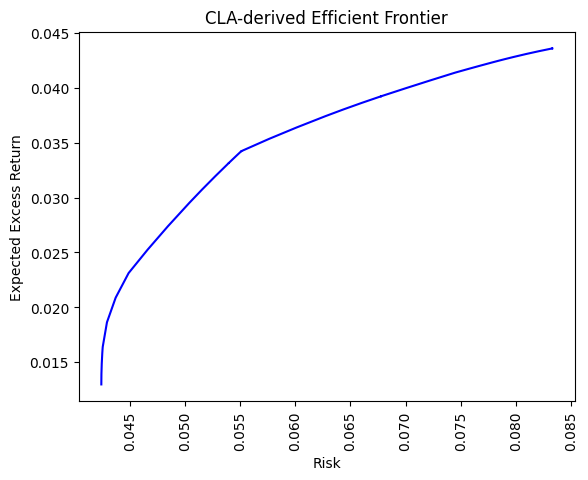

In [18]:
mu, sigma, weights = efFrontier(100)
plot2D(sigma, mu, "Risk", "Expected Excess Return", "CLA-derived Efficient Frontier")

In [19]:
sharpe, w_sharpe = getMaxSR()

In [20]:
w_sharpe

array([[0.  ],
       [0.1 ],
       [0.1 ],
       [0.1 ],
       [0.15],
       [0.07],
       [0.14],
       [0.07],
       [0.15],
       [0.07],
       [0.  ],
       [0.05]])

In [21]:
mean

array([[ 0.06829605],
       [ 0.16037765],
       [ 0.10357005],
       [ 0.10466963],
       [-0.00606009],
       [-0.02144889],
       [-0.00326421],
       [ 0.00391848],
       [-0.0033532 ],
       [-0.00586425],
       [ 0.02493536],
       [ 0.0173648 ]])

In [22]:
mean_sharpe = np.dot(w_sharpe.T, mean)[0, 0]

In [23]:
std_sharpe = np.dot(np.dot(w_sharpe.T, covar), w_sharpe)[0, 0] ** 0.5

In [24]:
sharpe, mean_sharpe, std_sharpe

(0.6211050246973796, 0.034223362231171894, 0.05510076536226142)

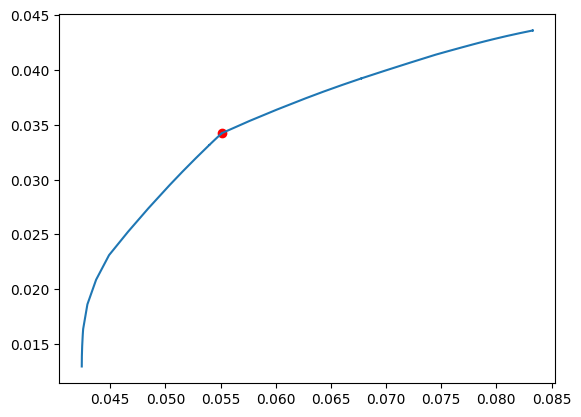

In [25]:
mpl.plot(sigma, mu)
mpl.scatter(std_sharpe, mean_sharpe, c="red")
mpl.show()

In [26]:
rets = []
stds = []
sharpes = []
for x in w_list:
    rx = np.dot(x.T, mean)[0, 0]
    stdx = np.dot(np.dot(x.T, covar), x)[0, 0] ** 0.5
    rets.append(rx)
    stds.append(stdx)
    sharpes.append(rx / stdx)

In [27]:
output = pd.DataFrame([rets, stds, sharpes]).transpose()

In [28]:
output.columns = ["ret", "std", "sharpe"]

In [29]:
output

,ret,std,sharpe
0,0.043595,0.083290,0.523407
1,0.043595,0.083290,0.523407
2,0.042830,0.079848,0.536396
3,0.042754,0.079539,0.537520
4,0.042344,0.077946,0.543249
5,0.041427,0.074629,0.555109
6,0.041382,0.074473,0.555665
7,0.041382,0.074473,0.555665
8,0.039233,0.067775,0.578865
9,0.039233,0.067775,0.578865


In [30]:
output["std"].argmin()

25

In [31]:
point_std = output.iloc[output["std"].argmin(), 1] / std_sharpe
point_mean = point_std * mean_sharpe

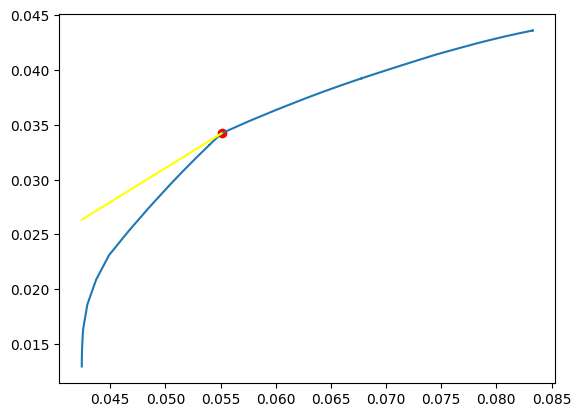

In [32]:
mpl.plot(sigma, mu)
mpl.scatter(std_sharpe, mean_sharpe, c="red")
mpl.plot(
    [output.iloc[output["std"].argmin(), 1], std_sharpe],
    [point_mean, mean_sharpe],
    c="yellow",
)
mpl.show()

In [33]:
optimal_pf = pd.Series(w_sharpe[:, 0], pd.MultiIndex.from_tuples(pf_components))

In [34]:
optimal_pf.groupby(level=[0]).sum()

Bond           0.65
Commodities    0.05
Equity         0.30
Real Estate    0.00
dtype: float64

In [35]:
sharpe, mean_sharpe, std_sharpe

(0.6211050246973796, 0.034223362231171894, 0.05510076536226142)

In [36]:
optimal_pf

Equity       ALAT.PA    0.00
             CSPX.L     0.10
             IJPE.L     0.10
             EMUL.SW    0.10
Bond         GOVT       0.15
             IBTS.AS    0.07
             IEAC.L     0.14
             LQDE.L     0.07
             SEGA.L     0.15
             SHYU.L     0.07
Real Estate  IPRP.AS    0.00
Commodities  SGLN.L     0.05
dtype: float64